<a href="https://colab.research.google.com/github/K-107/Anomaly-Detection/blob/main/Anomaly_Detection_with_Auto_Encoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글에서 신용카드 범죄 데이터 가져오기

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [7]:
! pip install -q kaggle
! mkdir -p /.kaggle
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [8]:
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:00<00:00, 77.5MB/s]
100% 66.0M/66.0M [00:00<00:00, 103MB/s] 


In [9]:
! unzip '*.zip'

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


# 오토인코더를 활용한 이상치 탐지

https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders

In [10]:
# 라이브러리 임포트 및 데이터 가져오기

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv('/content/creditcard.csv')
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [11]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [12]:
data.info()
# V1~V28까지는 뭔지도 모름. 초가 단위인 Time 변수, 거래 액수인 Amount
# 마지막으로 사기가 1이고 0이 정상인 Class

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [13]:
# 1시간은 3600초, 하루는 24시간. 즉, x / 3600 % 24는 x가 초일 때 몇시간 째인지 실수로 표현. 일자는 없앰.
# 10/3=3.3333, 10//3=3, 10%3=1

data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)

## data에서 사기(=1)와 정상(=0)의 비율

In [14]:
vc = data['Class'].value_counts()
vc

0    284315
1       492
Name: Class, dtype: int64

In [15]:
vc = vc.to_frame().reset_index()
vc

,index,Class
0,0,284315
1,1,492


In [16]:
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
# 284315 / ( 284315 + 492 ) = 0.9982725143693799
vc

,index,Class,percent
0,0,284315,99.83
1,1,492,0.17


In [17]:
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


## 정상 데이터 1000개랑 사기 492개를 tsne로 시각화 해보자.

In [18]:
non_fraud = data[data['Class'] == 0].sample(1000)
# .sample(n)은 n개 중에 하나를 뽑습니다. 결과를 보고 다시 넣지 않아요. 그러면 남은 공이 n-1개일 겁니다. 
# 또 뽑아야 한다면, n-1개 중에 하나를 뽑습니다. 비복원 추출이라고 생각하시면 편합니다.
# https://codingdog.tistory.com/entry/파이썬-sample-vs-choices-의-차이를-알아봅시다 [강아지의 코딩공부]

fraud = data[data['Class'] == 1]

In [19]:
non_fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
177464,10.218333,-0.104941,0.751601,0.225560,-0.748639,1.099622,0.395713,0.791145,0.200272,-0.169629,-0.572465,-0.073278,0.822614,0.705018,0.053902,0.329606,-1.079818,0.453406,-2.299365,-1.252597,-0.093242,-0.161553,-0.137934,0.155450,-0.948801,-0.700699,0.231562,0.305686,0.088287,0.89,0
231777,16.811389,-0.122409,1.149425,-2.611468,-0.618719,0.680058,-0.544380,2.006136,-0.079991,-0.641383,-1.115560,-1.445289,-1.087558,-0.959857,-0.224498,0.059058,0.447207,0.500196,0.400768,-0.283224,-0.293802,0.169556,0.358125,0.024278,-0.096492,-0.340016,0.525329,-0.151007,-0.020035,209.99,0
210722,14.360556,1.938091,0.089758,-1.238035,0.986414,-0.351128,-1.755183,0.193077,-0.359134,0.540036,-0.379631,0.270806,0.221923,-0.505855,-0.879059,0.187395,-0.086738,1.025133,-0.172574,-0.727871,-0.210702,0.138019,0.565442,0.142189,0.819158,-0.047255,0.403121,-0.043031,-0.026416,22.80,0
139729,23.143333,-0.839001,0.897658,2.142027,-0.596557,0.988985,0.511371,1.573387,-1.441615,0.897911,1.992622,1.828421,0.395080,0.740422,-1.552065,0.638367,-0.432761,-1.338756,0.000178,-0.129939,0.340211,0.109986,1.241138,-0.415167,-0.241730,-0.744454,0.075347,-2.385094,-1.713441,10.61,0
27056,9.546389,-1.046114,1.405435,0.212857,0.400113,0.484588,0.554874,0.134874,0.698825,-0.462015,0.338268,0.062455,-0.138232,-0.898117,0.888175,0.762913,0.053430,-0.374315,0.675784,0.752699,0.056509,0.118157,0.383796,-0.171989,-1.169311,-0.103967,-0.232531,0.278012,0.189607,5.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215218,14.882778,2.030266,0.270468,-1.528897,1.366130,0.479973,-1.058662,0.643861,-0.435881,0.130553,0.228794,-0.903499,0.700106,0.487794,0.359040,-0.556334,-0.702870,-0.212209,-0.733521,-0.200592,-0.252578,0.018640,0.313453,0.014571,-0.066154,0.431428,-0.533652,-0.006185,-0.059047,8.00,0
9480,3.904444,-0.883915,0.626987,0.066830,-0.454323,2.977583,3.573006,-0.000974,-0.246982,0.957364,-0.322838,0.748936,-2.745061,1.549154,1.595521,0.262971,0.344822,-0.318630,0.552853,0.081980,-0.308778,0.349629,-0.999722,0.428910,0.873347,-0.315289,-0.780460,-0.006177,-0.131398,9.99,0
14703,7.202222,1.127839,0.484605,0.724120,2.441885,-0.114231,-0.086099,-0.001373,0.083896,-0.611902,0.648628,-0.410710,-0.413561,-0.820920,0.485530,0.905639,0.524200,-0.322924,-0.814149,-1.275220,-0.224289,-0.227220,-0.755422,0.177897,-0.013374,0.144517,-0.233541,0.002908,0.024594,10.24,0
70134,14.923333,-1.542715,-0.215242,0.471353,-1.144273,-1.647514,0.372759,1.524489,0.282736,0.490575,-1.777123,1.360661,1.613034,0.071748,0.361018,-0.232477,-1.010877,0.359085,-0.173596,0.968496,-0.226464,-0.018600,0.248013,0.715797,0.227350,-0.165649,-0.892015,0.172093,-0.054318,372.00,0


In [20]:
fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,0.112778,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,0.131111,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,1.239444,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,1.940556,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,2.088611,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,22.983889,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,2.115795,-5.417424,-1.235123,-6.665177,0.401701,-2.897825,-4.570529,-1.315147,0.391167,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,23.040833,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,2.858466,-3.096915,-0.792532,-5.210141,-0.613803,-2.155297,-3.267116,-0.688505,0.737657,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,23.041944,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,1.794969,-2.775022,-0.418950,-4.057162,-0.712616,-1.603015,-5.035326,-0.507000,0.266272,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,23.212778,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,1.933520,-5.030465,-1.127455,-6.416628,0.141237,-2.549498,-4.614717,-1.478138,-0.035480,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [21]:
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
# sample(frac=1)을 이용하면 전체 데이터의 shuffling도 해볼 수 있다.
# 숫자는 비율을 뜻한다.
# https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=nomadgee&logNo=220812476823
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,12.478333,-0.469678,0.664138,-0.454818,-0.088011,0.171895,0.377215,2.261368,-0.807091,0.607520,-0.743045,-0.675437,-0.887246,-0.716423,-2.077123,0.413521,-0.413721,1.184001,0.425834,1.213612,-0.209313,-0.365171,-0.201331,-0.015075,0.305929,-0.564569,-0.074338,-0.290249,-0.329507,253.92,0
1,17.526389,0.970482,-0.847493,0.595211,0.567191,-0.826490,0.599934,-0.596635,0.183025,-0.931399,0.796579,0.818304,0.974713,0.756032,-0.068055,-0.254447,-1.458962,-0.161293,1.339229,-1.061250,-0.246233,-0.232898,-0.343392,-0.126469,-0.317010,0.353549,-0.319808,0.060416,0.042538,145.42,0
2,14.643611,-3.975939,-1.244939,-3.707414,4.544772,4.050676,-3.407679,-5.063118,1.007042,-3.190158,-4.250717,4.182162,-4.563675,1.182503,-6.964972,1.115340,-4.997332,-6.419539,-1.183593,3.569733,2.109403,1.059737,-0.037395,0.348707,-0.162929,0.410531,-0.123612,0.877424,0.667568,8.30,1
3,8.545278,1.502916,-0.410908,0.010381,-0.998518,-0.360623,-0.212083,-0.519417,-0.153563,-0.803499,0.581132,-1.288824,-0.516834,1.325463,-0.427494,0.787466,1.589942,-0.332204,-1.239559,1.138816,0.173309,-0.178176,-0.581688,-0.050204,-1.005451,0.449193,-0.396493,0.014454,0.010673,10.00,0
4,16.180833,-1.053308,0.588041,0.497243,0.514123,-0.243353,-1.143231,0.516954,0.188210,-0.619711,-0.367092,-0.788498,-0.646085,-1.139378,0.917944,1.042679,-0.161062,0.192981,-0.040230,0.725740,-0.083019,0.128897,0.083167,0.014889,0.415131,-0.413715,0.457807,-0.151270,0.062739,72.98,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,9.971944,-2.857170,4.045601,-4.197299,5.487199,-3.070776,-1.422686,-5.651314,2.019657,-5.015491,-6.319708,3.779602,-8.077094,1.440889,-7.891909,0.530453,-7.954070,-14.265056,-5.771064,2.892170,0.981609,1.080323,-0.561384,0.102678,-0.067195,-0.476931,-0.103716,1.166961,0.663632,1.00,1
1488,8.938333,2.223486,-1.500806,-0.644077,-1.797258,-1.130154,0.272245,-1.483661,0.105621,-1.294010,1.649984,0.471729,0.126625,1.068873,-0.542714,-0.570181,0.026113,-0.034521,0.354259,0.250912,-0.318245,-0.366698,-0.651640,0.420002,0.164178,-0.563207,-0.507434,0.032472,-0.039083,29.95,0
1489,14.829167,1.237815,-0.935983,1.018725,-0.713004,-1.546940,-0.094951,-1.297113,0.302919,-0.408348,0.776604,1.481802,-0.735965,-1.599314,0.146061,0.847184,1.408426,0.260348,-0.653221,0.083078,-0.014188,0.464792,1.167640,-0.054946,0.219666,0.230063,-0.045473,0.035535,0.013620,29.95,0
1490,23.041944,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,1.794969,-2.775022,-0.418950,-4.057162,-0.712616,-1.603015,-5.035326,-0.507000,0.266272,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1


In [22]:
X = df.drop(['Class'], axis = 1)
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,12.478333,-0.469678,0.664138,-0.454818,-0.088011,0.171895,0.377215,2.261368,-0.807091,0.607520,-0.743045,-0.675437,-0.887246,-0.716423,-2.077123,0.413521,-0.413721,1.184001,0.425834,1.213612,-0.209313,-0.365171,-0.201331,-0.015075,0.305929,-0.564569,-0.074338,-0.290249,-0.329507,253.92
1,17.526389,0.970482,-0.847493,0.595211,0.567191,-0.826490,0.599934,-0.596635,0.183025,-0.931399,0.796579,0.818304,0.974713,0.756032,-0.068055,-0.254447,-1.458962,-0.161293,1.339229,-1.061250,-0.246233,-0.232898,-0.343392,-0.126469,-0.317010,0.353549,-0.319808,0.060416,0.042538,145.42
2,14.643611,-3.975939,-1.244939,-3.707414,4.544772,4.050676,-3.407679,-5.063118,1.007042,-3.190158,-4.250717,4.182162,-4.563675,1.182503,-6.964972,1.115340,-4.997332,-6.419539,-1.183593,3.569733,2.109403,1.059737,-0.037395,0.348707,-0.162929,0.410531,-0.123612,0.877424,0.667568,8.30
3,8.545278,1.502916,-0.410908,0.010381,-0.998518,-0.360623,-0.212083,-0.519417,-0.153563,-0.803499,0.581132,-1.288824,-0.516834,1.325463,-0.427494,0.787466,1.589942,-0.332204,-1.239559,1.138816,0.173309,-0.178176,-0.581688,-0.050204,-1.005451,0.449193,-0.396493,0.014454,0.010673,10.00
4,16.180833,-1.053308,0.588041,0.497243,0.514123,-0.243353,-1.143231,0.516954,0.188210,-0.619711,-0.367092,-0.788498,-0.646085,-1.139378,0.917944,1.042679,-0.161062,0.192981,-0.040230,0.725740,-0.083019,0.128897,0.083167,0.014889,0.415131,-0.413715,0.457807,-0.151270,0.062739,72.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,9.971944,-2.857170,4.045601,-4.197299,5.487199,-3.070776,-1.422686,-5.651314,2.019657,-5.015491,-6.319708,3.779602,-8.077094,1.440889,-7.891909,0.530453,-7.954070,-14.265056,-5.771064,2.892170,0.981609,1.080323,-0.561384,0.102678,-0.067195,-0.476931,-0.103716,1.166961,0.663632,1.00
1488,8.938333,2.223486,-1.500806,-0.644077,-1.797258,-1.130154,0.272245,-1.483661,0.105621,-1.294010,1.649984,0.471729,0.126625,1.068873,-0.542714,-0.570181,0.026113,-0.034521,0.354259,0.250912,-0.318245,-0.366698,-0.651640,0.420002,0.164178,-0.563207,-0.507434,0.032472,-0.039083,29.95
1489,14.829167,1.237815,-0.935983,1.018725,-0.713004,-1.546940,-0.094951,-1.297113,0.302919,-0.408348,0.776604,1.481802,-0.735965,-1.599314,0.146061,0.847184,1.408426,0.260348,-0.653221,0.083078,-0.014188,0.464792,1.167640,-0.054946,0.219666,0.230063,-0.045473,0.035535,0.013620,29.95
1490,23.041944,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,1.794969,-2.775022,-0.418950,-4.057162,-0.712616,-1.603015,-5.035326,-0.507000,0.266272,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89


In [23]:
X = X.values
X
# .values은 데이터 프레임을 넘파이로 만들어준다.

array([[ 1.24783333e+01, -4.69678467e-01,  6.64138028e-01, ...,
        -2.90249217e-01, -3.29506840e-01,  2.53920000e+02],
       [ 1.75263889e+01,  9.70481912e-01, -8.47492750e-01, ...,
         6.04162068e-02,  4.25376526e-02,  1.45420000e+02],
       [ 1.46436111e+01, -3.97593926e+00, -1.24493887e+00, ...,
         8.77423851e-01,  6.67568430e-01,  8.30000000e+00],
       ...,
       [ 1.48291667e+01,  1.23781545e+00, -9.35982632e-01, ...,
         3.55347752e-02,  1.36201938e-02,  2.99500000e+01],
       [ 2.30419444e+01, -6.76142671e-01,  1.12636606e+00, ...,
         3.85107449e-01,  1.94361479e-01,  7.78900000e+01],
       [ 1.30361111e+01,  2.09212691e+00, -1.22863088e-02, ...,
        -1.50543753e-01, -1.00051523e-01,  1.00000000e+01]])

In [24]:
 Y = df["Class"].values

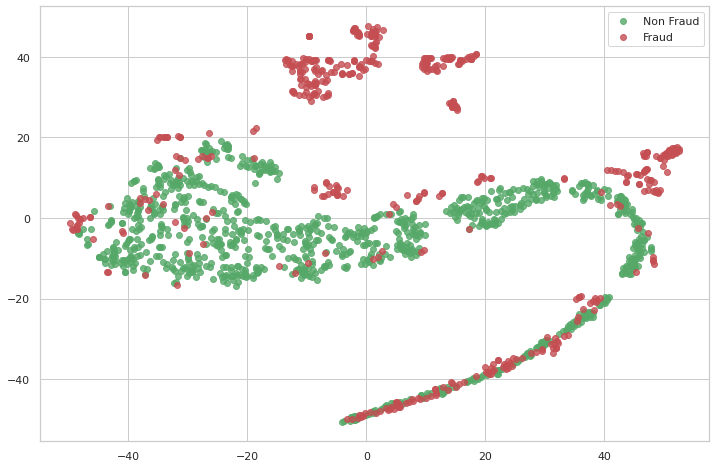

In [25]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

## 모델 설계

In [26]:
## input layer 
input_layer = Input(shape=(X.shape[1],)) # 열이 컬럼의 수이다.

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [27]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [32]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values
x

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,23.996111,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,23.996389,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,23.996667,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,23.996667,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [33]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_scale

array([[0.00000000e+00, 9.35192337e-01, 7.66490419e-01, ...,
        4.18976135e-01, 3.12696634e-01, 5.82379309e-03],
       [0.00000000e+00, 9.78541955e-01, 7.70066651e-01, ...,
        4.16345145e-01, 3.13422663e-01, 1.04705276e-04],
       [1.15743420e-05, 9.35217023e-01, 7.53117667e-01, ...,
        4.15489266e-01, 3.11911316e-01, 1.47389219e-02],
       ...,
       [9.99884257e-01, 9.90904812e-01, 7.64079694e-01, ...,
        4.16593177e-01, 3.12584864e-01, 2.64215395e-03],
       [9.99884257e-01, 9.54208999e-01, 7.72855742e-01, ...,
        4.18519535e-01, 3.15245157e-01, 3.89238944e-04],
       [9.99930554e-01, 9.49231759e-01, 7.65256401e-01, ...,
        4.16466371e-01, 3.13400843e-01, 8.44648509e-03]])

In [37]:
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]
# 불린 인덱싱!!!

In [29]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 3s 33ms/step - loss: 0.2651 - val_loss: 0.2640
Epoch 2/10
7/7 [==============================] - 0s 10ms/step - loss: 0.2648 - val_loss: 0.2637
Epoch 3/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2644 - val_loss: 0.2633
Epoch 4/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2641 - val_loss: 0.2630
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2637 - val_loss: 0.2626
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2633 - val_loss: 0.2623
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.2630 - val_loss: 0.2619
Epoch 8/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2626 - val_loss: 0.2616
Epoch 9/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2623 - val_loss: 0.2612
Epoch 10/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2619 - val_loss: 0.2608


In [30]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________

In [31]:
'''
이 부분이 중요한데, 인코더의 레이어 3개의 가중치를 가져와서 
그 가중치로 정상과 사기를 예측한다는 것이다.
정상은 정상데이터로 훈련된 인코더이므로 값이 예정대로 나올 것이고
사기는 인코더에서 첨 본 데이터이므로 튈 것이다.
'''
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [38]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [44]:
norm_hid_rep.shape, fraud_hid_rep.shape

((3000, 50), (492, 50))

## 모델을 통과한 정상과 사기의 분포 차이 시각화

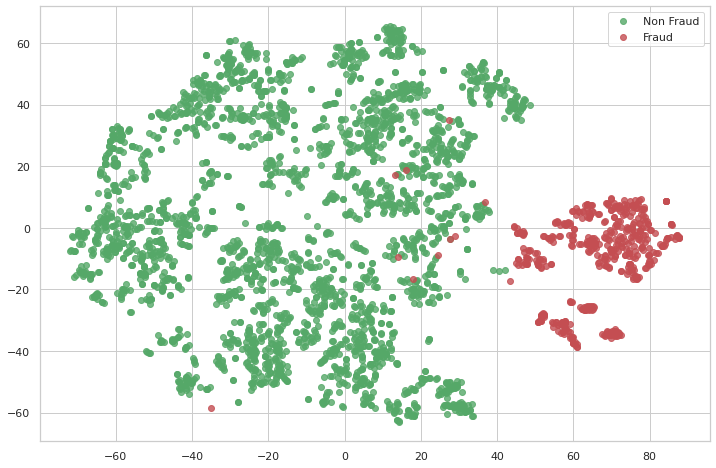

In [39]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
# 정상은 0, 사기는 1로 만든 rep_y
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

tsne_plot(rep_x, rep_y, "latent_representation.png")

In [40]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))

Actual Representation (Before),Latent Representation (Actual)
,


## 사기와 정상을 로지스틱 회귀로 분류한 결과

In [41]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       742
         1.0       1.00      0.89      0.94       131

    accuracy                           0.98       873
   macro avg       0.99      0.94      0.96       873
weighted avg       0.98      0.98      0.98       873


Accuracy Score:  0.9828178694158075
